<a href="https://colab.research.google.com/github/vedantgadhvi/Customer-Churn-Prediction/blob/main/Customer_Churn_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Customer Churn Prediction Project

This notebook predicts customer churn using machine learning models and interprets results using SHAP values.

**Step 1: - Setup and Installation**

In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

!pip install pinecone sentence-transformers umap-learn optuna lightgbm plotly shap lime imbalanced-learn lifelines -q

print("✅ All packages installed successfully!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.6/587.6 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 3.2 MB/s eta 0:00:00
✅ All packages installed successfully!


**Step 2: - Import Libraries**

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# ML Libraries
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from xgboost import XGBClassifier
import lightgbm as lgb

# Interpretability
import shap
import lime
from lime.lime_tabular import LimeTabularExplainer

# Vector Database (Updated Pinecone import)
from pinecone import Pinecone, ServerlessSpec
from sentence_transformers import SentenceTransformer
import umap

# Advanced Analytics
from lifelines import KaplanMeierFitter
import optuna
from imblearn.over_sampling import SMOTE

# Utilities
import time
from datetime import datetime
import json

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")

print("📚 All libraries imported successfully!")

📚 All libraries imported successfully!


**Step 3: - Basic Data Exploration**

In [5]:
# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/Customer Churn Prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv')

print("🔍 DATASET OVERVIEW")
print("=" * 50)
print(f"Dataset shape: {df.shape}")
print(f"Missing values: {df.isnull().sum().sum()}")
print(f"Columns: {list(df.columns)}")

# Display basic info
print("\n📋 Dataset Info:")
df.info()

print("\n📈 Target Variable Distribution:")
print(df['Churn'].value_counts())
print(f"Churn rate: {df['Churn'].value_counts(normalize=True)['Yes']:.2%}")

# Display first few rows
df.head()

🔍 DATASET OVERVIEW
Dataset shape: (7043, 21)
Missing values: 0
Columns: ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']

📋 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   Inter

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


**Step 4: - Advanced Exploratory Data Analysis**

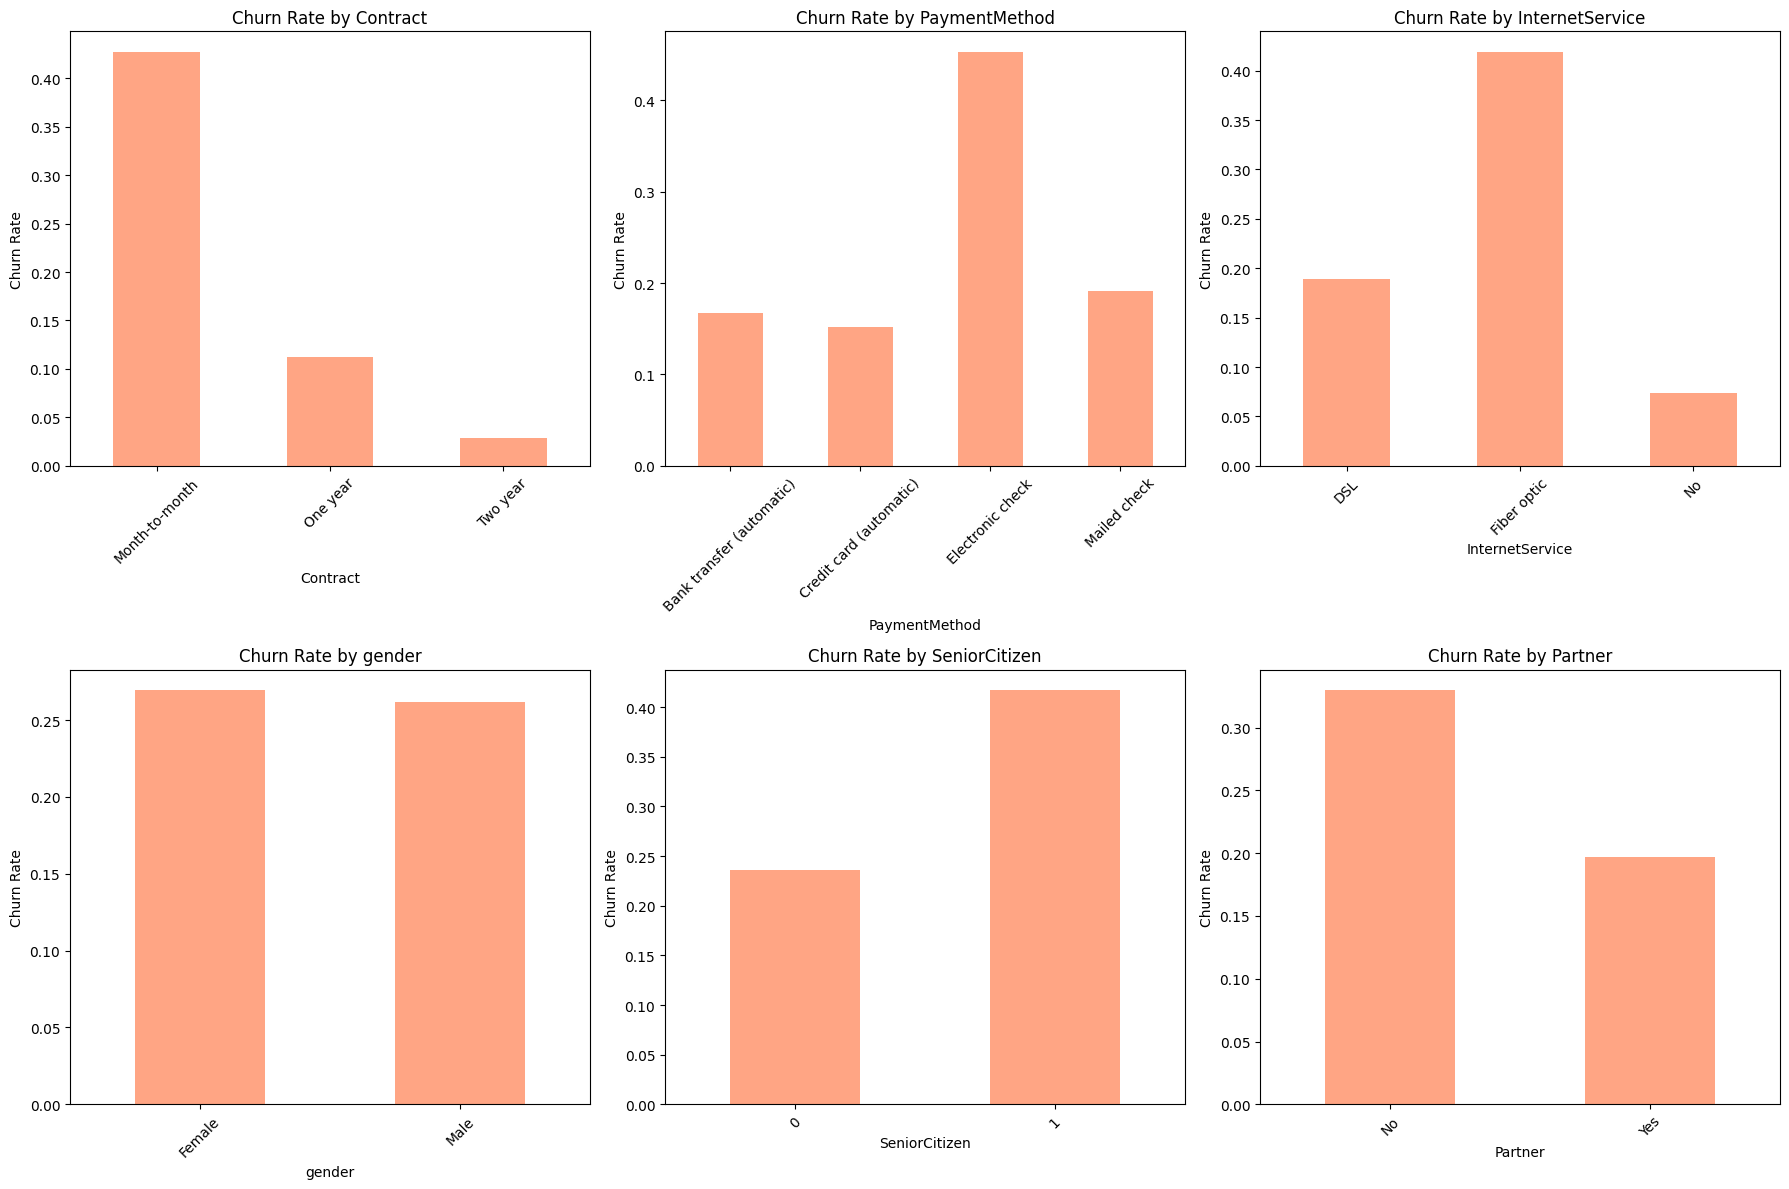

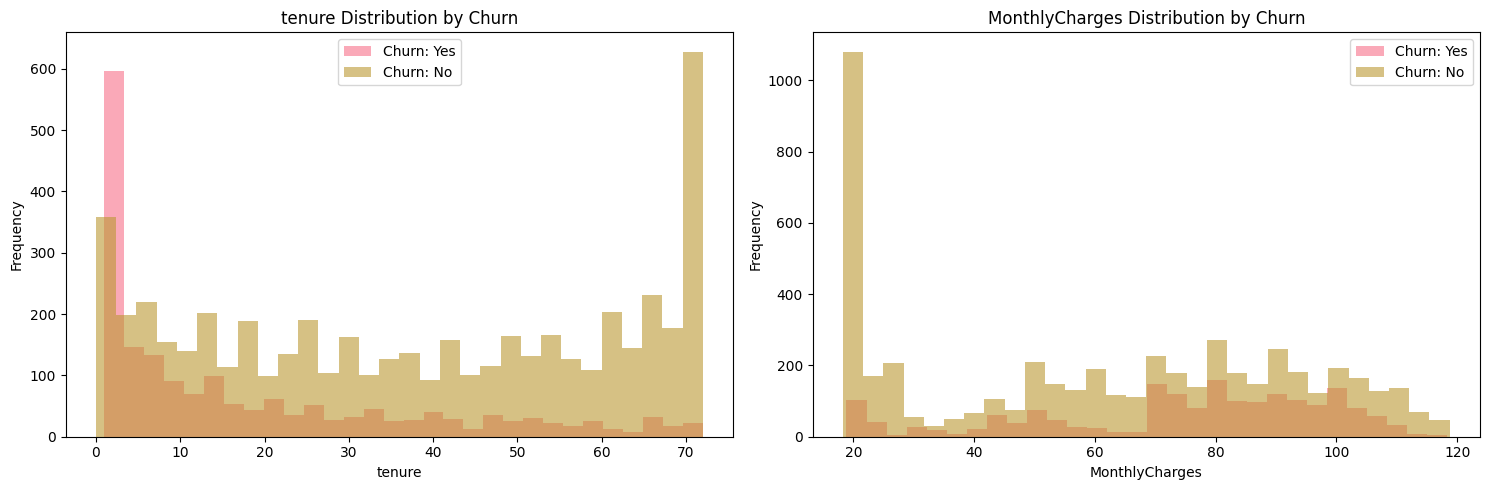

In [6]:
def create_advanced_eda(df):
    """Create comprehensive visualizations"""

    # 1. Churn rate by categorical variables
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    categorical_vars = ['Contract', 'PaymentMethod', 'InternetService', 'gender', 'SeniorCitizen', 'Partner']

    for i, var in enumerate(categorical_vars):
        row, col = i // 3, i % 3
        churn_rate = df.groupby(var)['Churn'].apply(lambda x: (x == 'Yes').mean())
        churn_rate.plot(kind='bar', ax=axes[row, col], color='coral', alpha=0.7)
        axes[row, col].set_title(f'Churn Rate by {var}')
        axes[row, col].set_ylabel('Churn Rate')
        axes[row, col].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    # 2. Numerical features distribution by churn
    numerical_cols = ['tenure', 'MonthlyCharges']
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    for i, col in enumerate(numerical_cols):
        for churn_status in ['Yes', 'No']:
            subset = df[df['Churn'] == churn_status][col]
            axes[i].hist(subset, alpha=0.6, label=f'Churn: {churn_status}', bins=30)

        axes[i].set_title(f'{col} Distribution by Churn')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Frequency')
        axes[i].legend()

    plt.tight_layout()
    plt.show()

    # 3. Interactive plotly visualization
    fig = px.box(
        df,
        x='Contract',
        y='MonthlyCharges',
        color='Churn',
        title='Monthly Charges Distribution by Contract Type and Churn Status'
    )
    fig.show()

    # 4. Services analysis
    service_cols = ['PhoneService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                   'TechSupport', 'StreamingTV', 'StreamingMovies']

    service_data = []
    for service in service_cols:
        for churn_status in ['Yes', 'No']:
            rate = (df[df['Churn'] == churn_status][service] == 'Yes').mean()
            service_data.append({
                'Service': service,
                'Churn': churn_status,
                'Adoption_Rate': rate
            })

    service_df = pd.DataFrame(service_data)

    fig = px.bar(
        service_df,
        x='Service',
        y='Adoption_Rate',
        color='Churn',
        barmode='group',
        title='Service Adoption Rates by Churn Status'
    )
    fig.update_layout(xaxis_tickangle=-45)
    fig.show()

# Run advanced EDA
create_advanced_eda(df)

**Step 5: - Data Preprocessing and Feature Engineering**

In [8]:
def preprocess_and_engineer_features(df):
    """Comprehensive data preprocessing and feature engineering"""

    df_processed = df.copy()

    print("🔧 Starting feature engineering...")

    # 1. Handle missing values and data types
    df_processed['TotalCharges'] = pd.to_numeric(df_processed['TotalCharges'], errors='coerce')
    missing_total_charges = df_processed['TotalCharges'].isnull().sum()
    print(f"   Missing TotalCharges: {missing_total_charges}")
    df_processed['TotalCharges'].fillna(df_processed['TotalCharges'].median(), inplace=True)

    # 2. Target encoding
    df_processed['Churn'] = df_processed['Churn'].map({'Yes': 1, 'No': 0})

    # 3. Remove customer ID
    df_processed.drop(['customerID'], axis=1, inplace=True)

    # 4. Advanced Feature Engineering

    # Service utilization features
    service_cols = ['PhoneService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                   'TechSupport', 'StreamingTV', 'StreamingMovies']

    for col in service_cols:
        df_processed[f'{col}_Binary'] = (df_processed[col] == 'Yes').astype(int)

    # Aggregate service features
    df_processed['TotalServices'] = df_processed[[f'{col}_Binary' for col in service_cols]].sum(axis=1)
    df_processed['ServiceUtilizationRate'] = df_processed['TotalServices'] / len(service_cols)

    # Financial features
    df_processed['AvgMonthlySpend'] = df_processed['TotalCharges'] / (df_processed['tenure'] + 1)
    df_processed['ChargesPerService'] = df_processed['MonthlyCharges'] / (df_processed['TotalServices'] + 1)
    df_processed['SpendingEfficiency'] = df_processed['TotalCharges'] / (df_processed['MonthlyCharges'] + 1)

    # Customer lifecycle features
    df_processed['TenureGroup'] = pd.cut(df_processed['tenure'],
                                        bins=[-1, 12, 24, 48, 72],
                                        labels=['New', 'Growing', 'Mature', 'Loyal'])

    df_processed['CustomerValue'] = (df_processed['MonthlyCharges'] * df_processed['tenure']).rank(pct=True)
    df_processed['HighValueCustomer'] = (df_processed['MonthlyCharges'] > df_processed['MonthlyCharges'].quantile(0.75)).astype(int)
    df_processed['LongTermCustomer'] = (df_processed['tenure'] > 36).astype(int)

    # Behavioral segmentation
    df_processed['HighMaintenanceCustomer'] = ((df_processed['TechSupport'] == 'Yes') |
                                              (df_processed['OnlineSecurity'] == 'No')).astype(int)

    df_processed['DigitalEngagement'] = ((df_processed['OnlineSecurity'] == 'Yes') |
                                        (df_processed['OnlineBackup'] == 'Yes') |
                                        (df_processed['StreamingTV'] == 'Yes') |
                                        (df_processed['StreamingMovies'] == 'Yes')).astype(int)

    # Contract and payment features
    df_processed['MonthToMonthContract'] = (df_processed['Contract'] == 'Month-to-month').astype(int)
    df_processed['AutomaticPayment'] = (df_processed['PaymentMethod'].isin(['Electronic check', 'Credit card (automatic)', 'Bank transfer (automatic)'])).astype(int)

    # One-hot encoding for remaining categorical variables
    categorical_features = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
                          'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                          'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
                          'PaperlessBilling', 'PaymentMethod', 'TenureGroup']

    df_processed = pd.get_dummies(df_processed, columns=categorical_features, drop_first=True)

    print(f"✅ Feature engineering complete!")
    print(f"📊 Final dataset shape: {df_processed.shape}")
    print(f"🎯 Total features created: {len(df_processed.columns) - 1}")

    # Display new feature summary
    new_features = ['TotalServices', 'ServiceUtilizationRate', 'AvgMonthlySpend',
                    'ChargesPerService', 'CustomerValue', 'HighValueCustomer',
                    'LongTermCustomer', 'DigitalEngagement']

    print("\n🆕 New Features Summary:")
    for feature in new_features:
        if feature in df_processed.columns:
            print(f"   {feature}: Mean={df_processed[feature].mean():.3f}, Std={df_processed[feature].std():.3f}")

    return df_processed

# Process the data
df_processed = preprocess_and_engineer_features(df)
df_processed.head()

🔧 Starting feature engineering...
   Missing TotalCharges: 11
✅ Feature engineering complete!
📊 Final dataset shape: (7043, 53)
🎯 Total features created: 52

🆕 New Features Summary:
   TotalServices: Mean=2.941, Std=1.844
   ServiceUtilizationRate: Mean=0.420, Std=0.263
   AvgMonthlySpend: Mean=61.173, Std=61.020
   ChargesPerService: Mean=17.082, Std=6.932
   CustomerValue: Mean=0.500, Std=0.289
   HighValueCustomer: Mean=0.250, Std=0.433
   LongTermCustomer: Mean=0.426, Std=0.495
   DigitalEngagement: Mean=0.645, Std=0.479


,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,PhoneService_Binary,OnlineSecurity_Binary,OnlineBackup_Binary,DeviceProtection_Binary,TechSupport_Binary,...,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,TenureGroup_Growing,TenureGroup_Mature,TenureGroup_Loyal
0,0,1,29.85,29.85,0,0,0,1,0,0,...,False,False,False,True,False,True,False,False,False,False
1,0,34,56.95,1889.50,0,1,1,0,1,0,...,False,True,False,False,False,False,True,False,True,False
2,0,2,53.85,108.15,1,1,1,1,0,0,...,False,False,False,True,False,False,True,False,False,False
3,0,45,42.30,1840.75,0,0,1,0,1,1,...,False,True,False,False,False,False,False,False,True,False
4,0,2,70.70,151.65,1,1,0,0,0,0,...,False,False,False,True,False,True,False,False,False,False


In [ ]:
X = df.drop('Churn', axis=1)
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, rf_preds))
print(classification_report(y_test, rf_preds))


Random Forest Accuracy: 0.7842441447835344
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1035
           1       0.62      0.48      0.54       374

    accuracy                           0.78      1409
   macro avg       0.72      0.69      0.70      1409
weighted avg       0.77      0.78      0.77      1409



In [ ]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)
xgb_preds = xgb.predict(X_test)
print("XGBoost Accuracy:", accuracy_score(y_test, xgb_preds))
print(classification_report(y_test, xgb_preds))


XGBoost Accuracy: 0.7771469127040455
              precision    recall  f1-score   support

           0       0.83      0.87      0.85      1035
           1       0.59      0.52      0.56       374

    accuracy                           0.78      1409
   macro avg       0.71      0.70      0.70      1409
weighted avg       0.77      0.78      0.77      1409



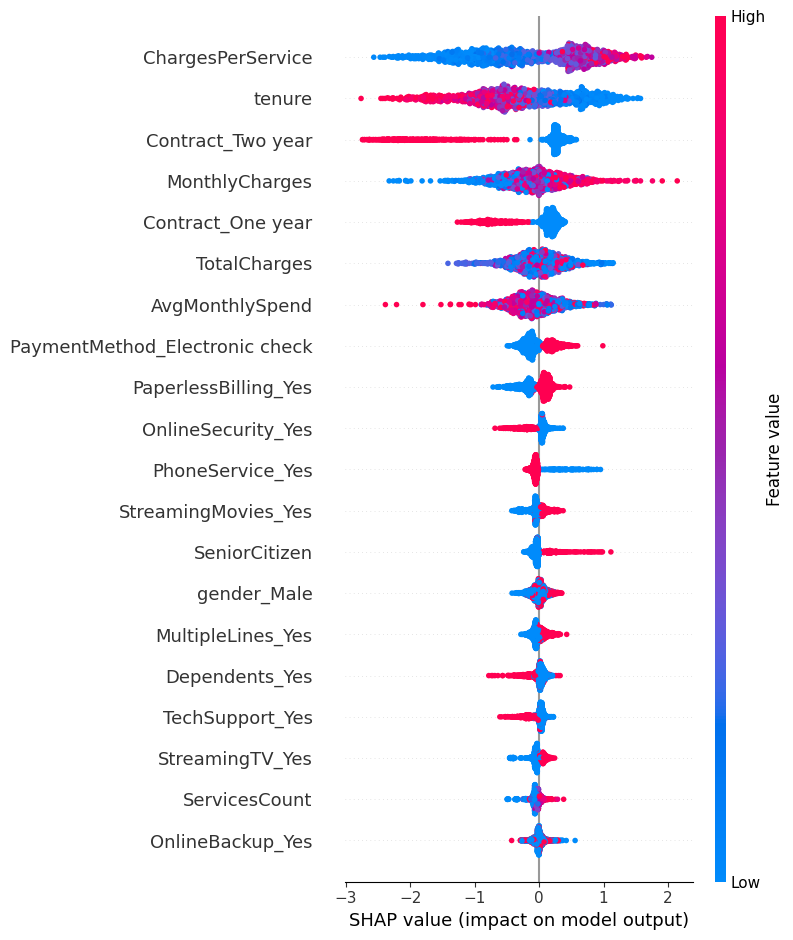

In [ ]:
explainer = shap.Explainer(xgb)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)
